In [2]:
!unzip /content/Fake.zip
!unzip /content/True.zip

!python -m spacy download en_core_web_lg


Archive:  /content/Fake.zip
  inflating: Fake.csv                
  inflating: __MACOSX/._Fake.csv     
Archive:  /content/True.zip
  inflating: True.csv                
  inflating: __MACOSX/._True.csv     


1. **Loading** **the** **Dataset**

In [3]:
import re
import nltk
import spacy
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_lg')

ps = PorterStemmer()
warnings.filterwarnings(action='ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
true = pd.read_csv('True.csv')
fake = pd.read_csv('Fake.csv')

In [15]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [16]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [13]:
true = pd.read_csv('True.csv')
fake = pd.read_csv('Fake.csv')

true['fake'] = 0
fake['fake'] = 1

df = pd.DataFrame()
df = true.append(fake)

del true
del fake

df = df.drop(columns = ['date','subject','text'])
df = df.sample(frac = 1)

df.head()

titles = np.array(df['title'])
titles


array(['U.N. condemns attack on Myanmar security forces, calls for calm',
       'At least 30 Burundian refugees die in clashes with Congolese security forces',
       'WOW! NAVY SEAL BLASTS HILLARY: “You Are An Ignorant Liar” [VIDEO]',
       ...,
       'HILLARY CLINTON SINGS “Song for Women” In Cameo On The Daily Show [Video]',
       'Slovakia a pro-European island in its region, PM says',
       'TRUMP BREAKS TRADITION Started By Bill Clinton…Doesn’t Host White House Ramadan Dinner…Had Other Plans [VIDEO]'],
      dtype=object)

In [11]:
for i in range (len('titles')):
   print(titles[i])
   news=titles[i].lower().split()
   print([word for word in news if not word in stopwords.words('english')])

Saudi Arabia condemns Myanmar government 'policy of repression'
['saudi', 'arabia', 'condemns', 'myanmar', 'government', "'policy", "repression'"]
 Trump Suspects Bannon Is The White House Leaker. But Who Leaked THAT?
['trump', 'suspects', 'bannon', 'white', 'house', 'leaker.', 'leaked', 'that?']
(VIDEO) DID HE JUST SAY THAT?! OBAMA DOWNPLAYS HORRIFIC CHLORINE GAS ATTACKS
['(video)', 'say', 'that?!', 'obama', 'downplays', 'horrific', 'chlorine', 'gas', 'attacks']
Rosneft CEO: U.S. sanctions will backfire, hurt U.S. energy majors
['rosneft', 'ceo:', 'u.s.', 'sanctions', 'backfire,', 'hurt', 'u.s.', 'energy', 'majors']
Iran halts flights to Iraq's Kurdish region in retaliation for independence vote
['iran', 'halts', 'flights', "iraq's", 'kurdish', 'region', 'retaliation', 'independence', 'vote']
 Kansas Governor Wants To Steal Money From State Investment Fund To Cover Budget Disaster He Caused
['kansas', 'governor', 'wants', 'steal', 'money', 'state', 'investment', 'fund', 'cover', 'budg

2. **Data** **Preprocessing**

In [5]:
corpus = []

for i in tqdm(range(len(titles))):
  news = re.sub(r'^a-zA-Z', '', titles[i])
  news = word_tokenize(news.lower())
  news = ' '.join([ps.stem(word) for word in news if not word in stopwords.words('english')])
  news = nlp(news).vector
  corpus.append(news)

X = np.array(corpus)

X_train = X[:40000]
y_train = df['fake'][:40000]
X_test  = X[40000:]
y_test  = df['fake'][40000:]

100%|██████████| 44898/44898 [11:06<00:00, 67.36it/s]


In [9]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (40000, 300)
y_train shape: (40000,)


3. **Training** **the** **Classifier**

In [6]:
classifier = LogisticRegression(random_state = 1, max_iter = 50)
classifier.fit(X_train,y_train)

LogisticRegression(max_iter=50, random_state=1)

4. **Model** **Evaluation**

[[2221  136]
 [ 159 2382]]
Accuracy :  93.98


<Axes: >

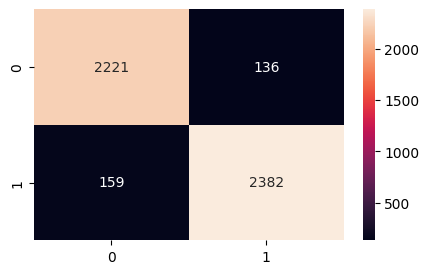

In [7]:
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test,y_pred)
print(cm)
print('Accuracy : ' , round(accuracy_score(y_test,y_pred)*100,2))

plt.figure(figsize = (5,3))
sns.heatmap(cm, annot = True, fmt = 'd')
